<a href="https://colab.research.google.com/github/ArwaSaif99/Movie-Recommendation-System/blob/main/Prac1Day2_ClimateIndicesCausalNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
##### It seems this block of code might not be necessary to run.
reqfile = 'requirements.txt'
f = open(reqfile, 'w')
f.write('''
netCDF4
xarray
numpy<1.24,>=1.18
scipy>=1.10.0
scikit-learn>=1.2
matplotlib>=3.7.0
seaborn>=0.12.2
gpytorch>=1.9.1
dcor>=0.6
joblib>=1.2.0
ortools>=9.2
numba>=0.58''')
f.close()
!pip install -r requirements.txt


In [ ]:
!pip install tigramite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.6/309.6 kB 254.7 kB/s eta 0:00:00


In [ ]:
import numpy as np
import scipy.stats as sps
import xarray as xr
import matplotlib.pyplot as plt
import sys, os

#import sklearn
#from sklearn.linear_model import LinearRegression
#from sklearn.preprocessing import StandardScaler

import tigramite
import tigramite.data_processing as pp
import tigramite.plotting as tp

#from tigramite.models import LinearMediation, Models
#from tigramite.causal_effects import CausalEffects

In [ ]:
import os
import urllib.request

# Mount google drive into this runtime
if not os.path.exists('/content/drive'):
    from google.colab import drive
    drive.mount('/content/drive')

# Define the data directory
yourdrive = '/content/drive/MyDrive/data/'

# Create the data directory if it doesn't exist
os.makedirs(yourdrive, exist_ok=True)

# Download SST data
sstdata = yourdrive + 'noaaoisst.mon.mean.nc'
if not os.path.exists(sstdata):
    url = 'https://downloads.psl.noaa.gov/Datasets/noaa.oisst.v2/sst.mnmean.nc'
    urllib.request.urlretrieve(url, sstdata)
    print(f"File downloaded to {sstdata}")
else:
    print(f"File already exists at {sstdata}")

# Download CMAP rainfall data
rainfall_cmap = yourdrive + 'cmapprecip.mon.mean.nc'
if not os.path.exists(rainfall_cmap):
    url = 'https://downloads.psl.noaa.gov/Datasets/cmap/std/precip.mon.mean.nc'
    urllib.request.urlretrieve(url, rainfall_cmap)
    print(f"File downloaded to {rainfall_cmap}")
else:
    print(f"File already exists at {rainfall_cmap}")

File downloaded to /content/drive/MyDrive/data/noaaoisst.mon.mean.nc
File downloaded to /content/drive/MyDrive/data/cmapprecip.mon.mean.nc


In [ ]:
indexdict={}
indexdict['NINO12'] = [-10,0,270,280]
indexdict['NINO3']  = [-5,5,210,270]
indexdict['NINO34'] = [-5,5,190,240]
indexdict['NINO4']  = [-5,5,160,210]
indexdict['BengNINO'] =  [-20,-10,8,15]
indexdict['SIOD']={'west': [-37,-27,55,65]}
indexdict['SIOD']['east']  = [-28,-18,90,100]
indexdict['IOD']={'west':[-10,10,50,70]}
indexdict['IOD']['east'] = [-10,0,90,110]
indexdict['SAsummerRain'] = [-32,-13,23,35]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
def climate_index(datafile,whichindex,varname='sst'):
    ''''''
    time_range = slice('1982-01-01','2022-12-31')
    indx = indexdict[whichindex]
    if isinstance(indx,list):
        lt1,lt2,ln1,ln2 = indx
        lat_range, lon_range = slice(lt2,lt1), slice(ln1,ln2)
        data_area = xr.open_dataset(datafile).sel(lat=lat_range,lon=lon_range,time=time_range)
        dtime = data_area.time
        timemonth = dtime.dt.month
        # index = data_area.mean('lon').mean('lat') ### Alt. using xarray
        data = data_area[varname]
        index = np.nanmean(data,(1,2)) # Ensures nans are managed
        index_anoms = np.zeros(index.shape)
        index_std = np.zeros(index.shape)
        for i in range(1,13):
            ix = np.where(timemonth[:] == i+1)
            index_std[ix] = sps.zscore(index[ix])
            index_anoms[ix] = index[ix]-np.nanmean(index[ix])
    elif isinstance(indx,dict):
        index_std_dict = {}
        for ky in ['west','east']:
            lt1,lt2,ln1,ln2 = indx[ky]
            lat_range, lon_range = slice(lt2,lt1), slice(ln1,ln2)
            data_area = xr.open_dataset(datafile).sel(lat=lat_range,lon=lon_range,time=time_range)
            dtime = data_area.time
            timemonth = dtime.dt.month
            # index = data_area.mean('lon').mean('lat') ### Alt. using xarray
            data = data_area[varname]
            index = np.nanmean(data,(1,2)) # Ensures nans are managed
            index_anoms = np.zeros(index.shape)
            index_std = np.zeros(index.shape)
            for i in range(1,13):
                ix = np.where(timemonth[:] == i+1)
                index_std[ix] = sps.zscore(index[ix])
                index_anoms[ix] = index[ix]-np.nanmean(index[ix])
            index_std_dict[ky] = index_std
        index_std = index_std_dict['west'] - index_std_dict['east']

    #return dtime, index_std, index_anoms, index
    return dtime, index_std

In [ ]:
dtime, nino34 = climate_index(sstdata,'NINO34')
dtime, siod = climate_index(sstdata,'SIOD')
dtime, iod = climate_index(sstdata,'IOD')
dtime, bnino = climate_index(sstdata,'BengNINO')
dtime, sa_rain = climate_index(rainfall_cmap,'SAsummerRain',varname='precip')

<ipython-input-7-8272fb2a283c>:19: RuntimeWarning: Mean of empty slice
  index_anoms[ix] = index[ix]-np.nanmean(index[ix])
<ipython-input-7-8272fb2a283c>:36: RuntimeWarning: Mean of empty slice
  index_anoms[ix] = index[ix]-np.nanmean(index[ix])
<ipython-input-7-8272fb2a283c>:36: RuntimeWarning: Mean of empty slice
  index_anoms[ix] = index[ix]-np.nanmean(index[ix])
<ipython-input-7-8272fb2a283c>:36: RuntimeWarning: Mean of empty slice
  index_anoms[ix] = index[ix]-np.nanmean(index[ix])
<ipython-input-7-8272fb2a283c>:36: RuntimeWarning: Mean of empty slice
  index_anoms[ix] = index[ix]-np.nanmean(index[ix])
<ipython-input-7-8272fb2a283c>:19: RuntimeWarning: Mean of empty slice
  index_anoms[ix] = index[ix]-np.nanmean(index[ix])
<ipython-input-7-8272fb2a283c>:19: RuntimeWarning: Mean of empty slice
  index_anoms[ix] = index[ix]-np.nanmean(index[ix])


(<Figure size 640x480 with 5 Axes>,
 array([<Axes: ylabel='nino34'>, <Axes: ylabel='siod'>,
        <Axes: ylabel='iod'>, <Axes: ylabel='Bnino'>,
        <Axes: ylabel='SA_rain'>], dtype=object))

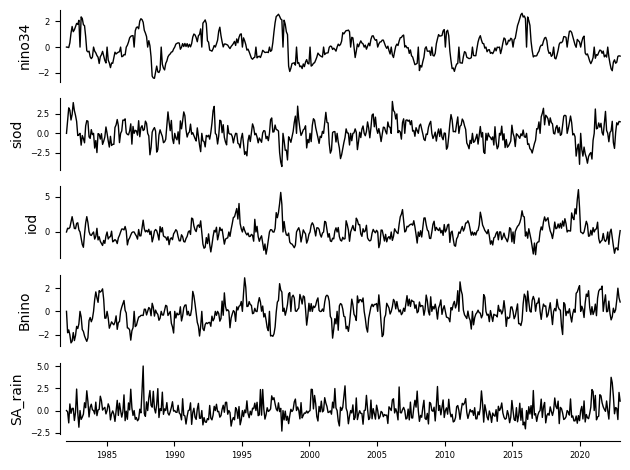

In [ ]:
data = np.vstack((nino34,siod,iod,bnino,sa_rain)).T
var_names = ['nino34','siod','iod', 'Bnino','SA_rain']

decimal_year = dtime.dt.year + (dtime.dt.month/12.-1/24.) # mid-month decimal yr

dataframe = pp.DataFrame(data,datatime = decimal_year, var_names=var_names)
tp.plot_timeseries(dataframe)

In [ ]:
correlation_matrix = np.corrcoef(data.T)
#### Print table of correlations with variable names
print('Correlation matrix: Full time series')
print('-----------------')
print('      ',end='    ')
for var in var_names:
    print(f'{var:6s}',end='  ')
print('    ')
for i, var in enumerate(var_names):
    print(f'{var:6s}',end='')
    for j in range(5):
        print(f'{correlation_matrix[i,j]:8.2f}',end='')
    print('')

Correlation matrix: Full time series
-----------------
          nino34  siod    iod     Bnino   SA_rain      
nino34    1.00   -0.09    0.33   -0.21   -0.17
siod     -0.09    1.00   -0.00   -0.12    0.12
iod       0.33   -0.00    1.00    0.05   -0.02
Bnino    -0.21   -0.12    0.05    1.00   -0.09
SA_rain   -0.17    0.12   -0.02   -0.09    1.00


In [ ]:
maskNDJF = np.ones(data.shape, dtype=bool)
dtmonths=dtime.dt.month
for ix,mn in enumerate(dtmonths):
        if mn in [10,11,12,1,2,3]:
            maskNDJF[ix,:] = False

ixNDJF = np.where(~maskNDJF[:,0])[0]

In [ ]:
dataNDJF=data[ixNDJF,:]
correlation_matrix = np.corrcoef(dataNDJF.T)
#### Print table of correlations with variable names
print('Correlation matrix: NDJF')
print('-----------------')
print('      ',end='    ')
for var in var_names:
    print(f'{var:6s}',end='  ')
print('    ')
for i, var in enumerate(var_names):
    print(f'{var:6s}',end='')
    for j in range(5):
        print(f'{correlation_matrix[i,j]:8.2f}',end='')
    print('')

Correlation matrix: NDJF
-----------------
          nino34  siod    iod     Bnino   SA_rain      
nino34    1.00   -0.24    0.34   -0.03   -0.38
siod     -0.24    1.00   -0.21   -0.04    0.13
iod       0.34   -0.21    1.00    0.21   -0.05
Bnino    -0.03   -0.04    0.21    1.00   -0.10
SA_rain   -0.38    0.13   -0.05   -0.10    1.00


In [ ]:
nino34smoothed = pp.smooth(nino34, smooth_width=3, kernel='heaviside',mask=None, residuals=False)
siodsmoothed = pp.smooth(siod, smooth_width=3, kernel='heaviside',mask=None, residuals=False)
iodsmoothed = pp.smooth(iod, smooth_width=3, kernel='heaviside',mask=None, residuals=False)
bninosmoothed = pp.smooth(bnino, smooth_width=3, kernel='heaviside',mask=None, residuals=False)
sa_rainsmoothed = pp.smooth(sa_rain, smooth_width=3, kernel='heaviside',mask=None, residuals=False)
data_3m = np.vstack((nino34smoothed,siodsmoothed,iodsmoothed,bninosmoothed,sa_rainsmoothed)).T

In [ ]:
dataNDJF=data_3m[ixNDJF,:]
correlation_matrix = np.corrcoef(dataNDJF.T)
#### Print table of correlations with variable names
print('Correlation matrix: NDJF smoothed data')
print('-----------------')
print('      ',end='    ')
for var in var_names:
    print(f'{var:6s}',end='  ')
print('    ')
for i, var in enumerate(var_names):
    print(f'{var:6s}',end='')
    for j in range(5):
        print(f'{correlation_matrix[i,j]:8.2f}',end='')
    print('')

Correlation matrix: NDJF smoothed data
-----------------
          nino34  siod    iod     Bnino   SA_rain      
nino34    1.00   -0.24    0.38   -0.09   -0.46
siod     -0.24    1.00   -0.24   -0.04    0.16
iod       0.38   -0.24    1.00    0.24   -0.11
Bnino    -0.09   -0.04    0.24    1.00   -0.06
SA_rain   -0.46    0.16   -0.11   -0.06    1.00


(<Figure size 640x480 with 5 Axes>,
 array([<Axes: ylabel='nino34'>, <Axes: ylabel='siod'>,
        <Axes: ylabel='iod'>, <Axes: ylabel='Bnino'>,
        <Axes: ylabel='SA_rain'>], dtype=object))

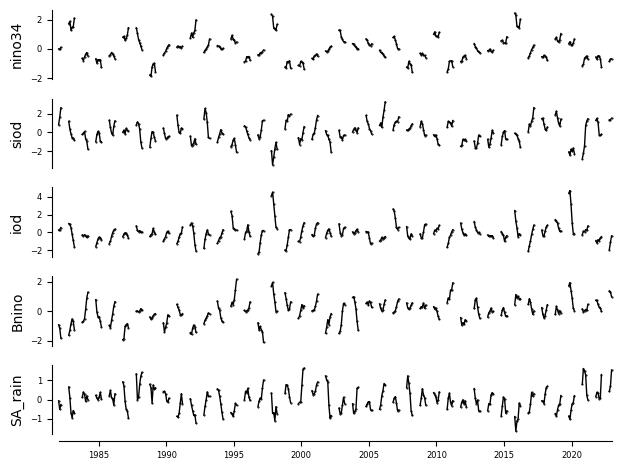

In [ ]:
dataframe = pp.DataFrame(np.copy(data_3m), datatime=decimal_year, var_names=var_names, mask=maskNDJF)
tp.plot_timeseries(dataframe)

In [ ]:
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr

In [ ]:
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe,
    cond_ind_test=parcorr,
    verbosity=1)
correlations = pcmci.get_lagged_dependencies(tau_max=3, val_only=True)['val_matrix']


##
## Estimating lagged dependencies 
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 3


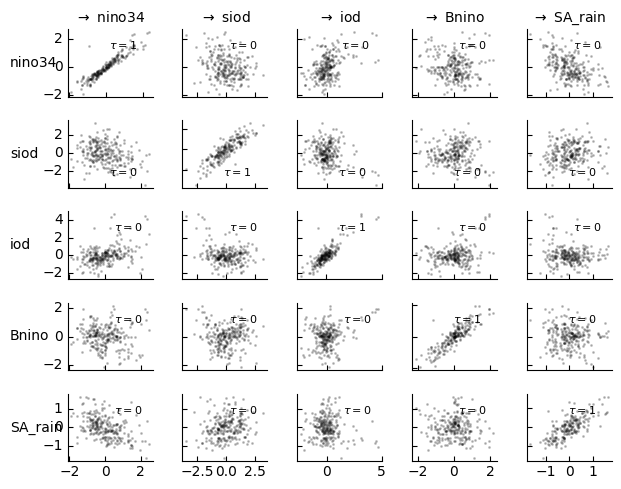

In [ ]:
matrix_lags = None #np.argmax(np.abs(correlations), axis=2)
tp.plot_scatterplots(dataframe=dataframe, add_scatterplot_args={'matrix_lags':matrix_lags}); plt.show()

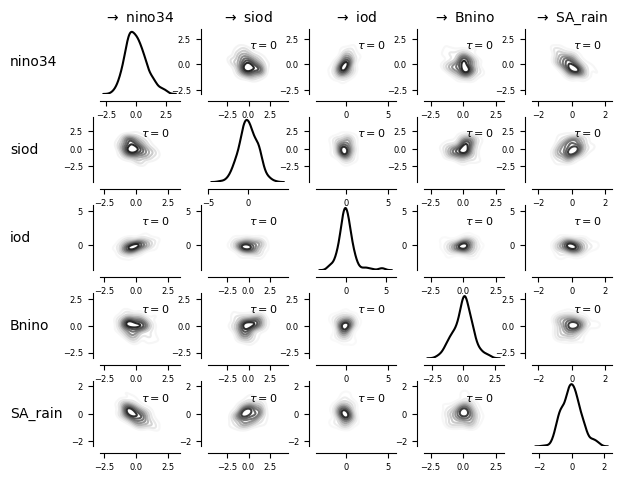

In [ ]:
tp.plot_densityplots(dataframe=dataframe, add_densityplot_args={'matrix_lags':matrix_lags})
plt.show()


##
## Estimating lagged dependencies 
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 3


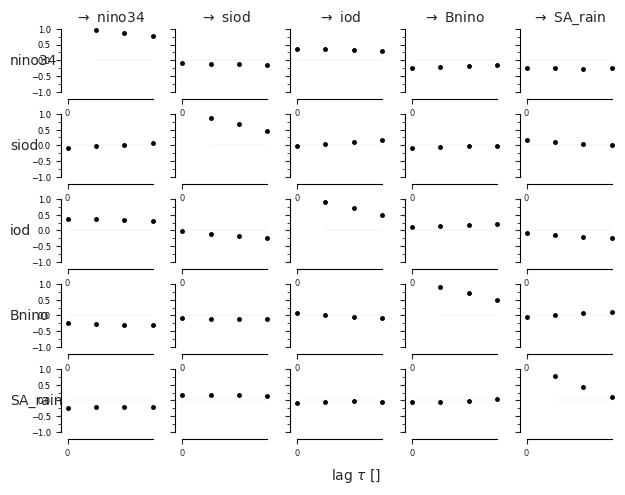

In [ ]:
correlations = pcmci.get_lagged_dependencies(tau_max=3, val_only=True)['val_matrix']
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, setup_args={'var_names':var_names, 'x_base':5, 'y_base':.5}); plt.show()

Now for rest of today, try to build a hypothesize causal effect graph. We'll be providing less and less instruction as you learn the material yourselves. So to build this graph start by following the tutorial on tigramite that Jakob Runge as set up.

1. https://github.com/jakobrunge/tigramite
2. Find tutorials --> case studies --> climate case study
3. See information on build graph and then try to do this yourselves.